# 母平均の比較値との差のz検定
- sympyとscipyで試してみる
- statsmodels
- R

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import sympy
from sympy import symbols, Symbol, Rational

In [2]:
import sys
print(sys.version)

3.5.2 |Anaconda custom (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]


In [3]:
%load_ext rpy2.ipython

In [4]:
import rpy2
rpy2.__version__

'2.8.5'

In [5]:
!R --version

R version 3.4.0 (2017-04-21) -- "You Stupid Darkness"
Copyright (C) 2017 The R Foundation for Statistical Computing
Platform: x86_64-apple-darwin15.6.0 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under the terms of the
GNU General Public License versions 2 or 3.
For more information about these matters see
http://www.gnu.org/licenses/.



In [6]:
sympy.init_printing()

### データ準備

In [7]:
np.random.seed(0)
mean = 1183000
std = 101000
size = 250
other_mean = 1150000
x = np.random.normal(size=size)
x.mean(), x.std()


平均と標準偏差を調整する

In [8]:
x1 = x / x.std() * std
x1 = x1 + (mean - x1.mean())
x1.mean(), x1.std()


In [9]:
x2 = x + (other_mean - x.mean())
x2.mean(), x2.std()

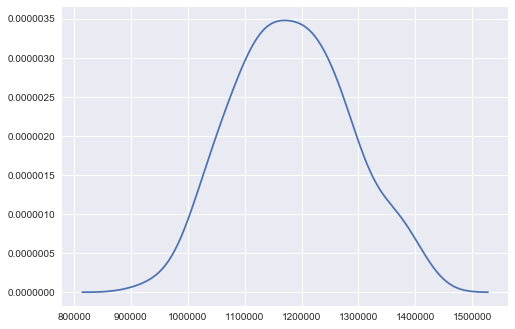

In [10]:
sns.kdeplot(x1)

### 検定統計量

In [11]:
x_, μ0, σ, n = symbols("\overline{x} mu_0 sigma n")
x_, μ0, σ, n 

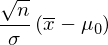

In [12]:
T = (x_ -  μ0) / (σ / sympy.sqrt(n))
T

symbolを用意して式を組み立てたが、定義どおりの形にならない

In [13]:
sympy.S("x - mu_0")

In [14]:
#sympy.S("overline{x} + 1")

- アルファベット順のため定義どおりの順序にならない
- latexの一部は自由に使えない

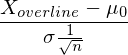

In [15]:
T = sympy.S("(X_overline - mu_0) / (sigma / sqrt(n))", evaluate=False)
T

妥協して順序を考慮した式の組み立てに成功

### 検定統計量の算出

書籍と同じ値になることの確認

In [16]:
T_value = T.subs(
    dict(
        X_overline=mean,
        mu_0=other_mean,
        sigma=std,
        n=size)).evalf()
T_value

有意水準0.05片側での統計量の確認

有意であるか確認

In [17]:
stats.norm.ppf(1 - 0.05)

書籍と同じ値で確認

In [18]:
stats.norm.sf(5.17)

In [19]:
1 - stats.norm.cdf(float(T_value))

不偏の場合？の確認

In [20]:
T_value_n_1 = T.subs(
    dict(
        X_overline=mean,
        mu_0=other_mean,
        sigma=std,
        n=size-1)).evalf()
T_value_n_1

In [21]:
1 - stats.norm.cdf(float(T_value_n_1))

### (おまけ)Sympyの式のグラフ化

In [22]:
sympy.srepr(T)

"Mul(Pow(Mul(Symbol('sigma'), Pow(Pow(Symbol('n'), Rational(1, 2)), Integer(-1))), Integer(-1)), Add(Symbol('X_overline'), Mul(Integer(-1), Symbol('mu_0'))))"

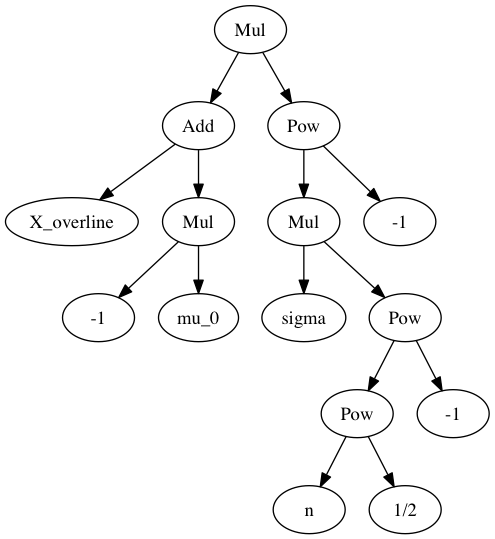

In [23]:
from sympy.printing.dot import dotprint
import pydot_ng
from IPython.display import Image

graph = pydot_ng.graph_from_dot_data(dotprint(T))  
Image(graph.create_png())

## statsmodels
3とおり

1. ztest function
2. descriptive statistics and tests with weights for case weights
3. class for two sample comparison (2を利用)


### 1. ztest function 
http://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ztest.html

- データセット１つとその他の平均値
- データセット２つ

In [24]:
sm.stats.ztest(x1, alternative="larger", value=other_mean)

In [25]:
sm.stats.ztest(x1, x2=x2, alternative="larger")


### 自由度の変更

In [26]:
sm.stats.ztest(x1, alternative="larger", value=other_mean, ddof=0)

### 2. descriptive statistics and tests with weights for case weights
http://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.DescrStatsW.html

In [27]:
d1 = sm.stats.DescrStatsW(x1)
d2 = sm.stats.DescrStatsW(x2)
d1

In [28]:
d1.ztest_mean(other_mean, alternative="larger")

### 3. class for two sample comparison (2を利用)
http://www.statsmodels.org/devel/generated/statsmodels.stats.weightstats.CompareMeans.html

In [29]:
compare_means = sm.stats.CompareMeans(d1, d2)
compare_means

In [30]:
compare_means.ztest_ind(alternative="larger")

## R

z.testはなかったので、単純に計算

- http://rpy.sourceforge.net/rpy2/doc-2.4/html/interactive.html
- https://www.slideshare.net/Prunus1350/5-r-14210894

In [31]:
%%R -i x1 --input std -i size -i other_mean --output r2py_output

Z分子 <- mean(x1) - other_mean
Z分母 <- std / sqrt(size)
Z統計量 <- Z分子 / Z分母
p値 <- pnorm(Z統計量, lower.tail = FALSE)
r2py_output <- c(Z統計量, p値)
r2py_output

[1] 5.166097e+00 1.195163e-07


In [32]:
r2py_output

array([  5.16609717e+00,   1.19516280e-07])

### 下記を参考にscipyとの対応を確認できるようにしておく
http://cse.naro.affrc.go.jp/takezawa/r-tips/r/60.html


In [33]:
%%R

# for help
?dnorm


R Help on ‘dnorm’Normal                  package:stats                  R Documentation

_T_h_e _N_o_r_m_a_l _D_i_s_t_r_i_b_u_t_i_o_n

_D_e_s_c_r_i_p_t_i_o_n:

     Density, distribution function, quantile function and random
     generation for the normal distribution with mean equal to ‘mean’
     and standard deviation equal to ‘sd’.

_U_s_a_g_e:

     dnorm(x, mean = 0, sd = 1, log = FALSE)
     pnorm(q, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
     qnorm(p, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
     rnorm(n, mean = 0, sd = 1)
     
_A_r_g_u_m_e_n_t_s:

    x, q: vector of quantiles.

       p: vector of probabilities.

       n: number of observations. If ‘length(n) > 1’, the length is
          taken to be the number required.

    mean: vector of means.

      sd: vector of standard deviations.

log, log.p: logical; if TRUE, probabilities p are given as log(p).

lower.tail: logical; if TRUE (default), probabi

In [34]:
%%R
norm_list <- list()

set.seed(0)

norm_list[["pdf_dnorm"]] <- dnorm(5.17)
norm_list[["cdf_pnrom_T"]] <- pnorm(5.17, lower.tail = T)
norm_list[["cdf_pnrom_F"]] <- pnorm(5.17, lower.tail = F)
norm_list[["quantile_qnorm_T"]] <- qnorm(0.05, lower.tail = T)
norm_list[["quantile_qnorm_F"]] <- qnorm(0.05, lower.tail = F)
norm_list[["random_variable_rnorm"]] <- rnorm(n=10, mean=5, sd=10)

norm_list

#      dnorm(x, mean = 0, sd = 1, log = FALSE)
#      pnorm(q, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
#      qnorm(p, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
#      rnorm(n, mean = 0, sd = 1)


$pdf_dnorm
[1] 6.263299e-07

$cdf_pnrom_T
[1] 0.9999999

$cdf_pnrom_F
[1] 1.17047e-07

$quantile_qnorm_T
[1] -1.644854

$quantile_qnorm_F
[1] 1.644854

$random_variable_rnorm
 [1]  17.629543   1.737666  18.297993  17.724293   9.146414 -10.399500
 [7]  -4.285670   2.052796   4.942328  29.046534

